# Emotional Classification in Social Media Text 

This notebook trains and compares five models on your datasets:

1. **Linear SVM + TF‑IDF** (baseline)
2. **Bi‑LSTM** (Keras)
3. **Text CNN** (Keras)
4. **DistilBERT** (Hugging Face Transformers, fine‑tuned)
5. **RoBERTa‑base** (Hugging Face Transformers, fine‑tuned)

### Expected data format
Three CSV files with columns:
- `text`: the input text (string)
- `label`: the target class as integer IDs (e.g., 0..K-1)


In [145]:
# install kaggle library
!pip install kaggle --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [146]:
import os
import shutil

In [147]:
# Download Data
!mkdir -p /content/data
!kaggle datasets download -d parulpandey/emotion-dataset -p /content/data

mkdir: /content: Read-only file system


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Dataset URL: https://www.kaggle.com/datasets/parulpandey/emotion-dataset
License(s): CC0-1.0
[Errno 30] Read-only file system: '/content'


In [148]:
import zipfile
import glob

zip_files = glob.glob("/content/data/*.zip")
print("Found zip files:", zip_files)

for z in zip_files:
    with zipfile.ZipFile(z, 'r') as zip_ref:
        zip_ref.extractall("/content/data")
    print(f"Unzipped {z}")

Found zip files: []


In [149]:
# !pip install -U numpy pandas scikit-learn nltk torch torchvision torchaudio transformers accelerate datasets tensorflow
import os, re, random, math, json, time
from typing import List, Dict, Tuple
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
colors = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(colors))
matplotlib.rcParams['figure.figsize'] = 12, 8

os.environ.setdefault('TF_CPP_MIN_LOG_LEVEL', '2')  # silence TF warnings

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    try:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    except Exception:
        pass
    try:
        import tensorflow as tf
        tf.random.set_seed(seed)
    except Exception:
        pass

set_seed(42)
print('Imports ready')


Imports ready


In [150]:
# === Config ===
TRAIN_PATH = '/Users/nelmierandikudagodage/Downloads/archive/training.csv'
VAL_PATH   = '/Users/nelmierandikudagodage/Downloads/archive/validation.csv'
TEST_PATH  = '/Users/nelmierandikudagodage/Downloads/archive/test.csv'

# Choose which models to run: {'svm','bilstm','cnn','distilbert','roberta'}
RUN_MODELS = {'svm', 'bilstm', 'cnn', 'distilbert', 'roberta'}  # one at a time assifn to the variable

OUTPUT_DIR = 'outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print('Output dir:', OUTPUT_DIR)


Output dir: outputs


In [151]:
# === Data Loading ===
def load_csvs(train_path: str, val_path: str, test_path: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    for p in [train_path, val_path, test_path]:
        if not os.path.exists(p):
            raise FileNotFoundError(f'File not found: {p}')
    train_df = pd.read_csv(train_path)
    val_df   = pd.read_csv(val_path)
    test_df  = pd.read_csv(test_path)
    expected = {'text','label'}
    for name, df in [('train', train_df), ('val', val_df), ('test', test_df)]:
        if not expected.issubset(df.columns):
            raise ValueError(f"{name}.csv must have cols {expected}. Found: {df.columns.tolist()}")
    return train_df, val_df, test_df

train_df, val_df, test_df = load_csvs(TRAIN_PATH, VAL_PATH, TEST_PATH)
print('Train shape:', train_df.shape, '| Val shape:', val_df.shape, '| Test shape:', test_df.shape)
display(train_df.head())
print('\nLabel distribution (train):\n', train_df['label'].value_counts().sort_index())


Train shape: (16000, 2) | Val shape: (2000, 2) | Test shape: (2000, 2)


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3



Label distribution (train):
 label
0    4666
1    5362
2    1304
3    2159
4    1937
5     572
Name: count, dtype: int64


### Creating a column with label names.¶
The label column currently has integers. To make it more understandable, we’ll create a new column called description containing the description of each integer in the label column.

In [152]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train_df['description'] = train_df['label'].map(labels_dict )
train_df.head()

,text,label,description
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


<Axes: xlabel='count', ylabel='description'>

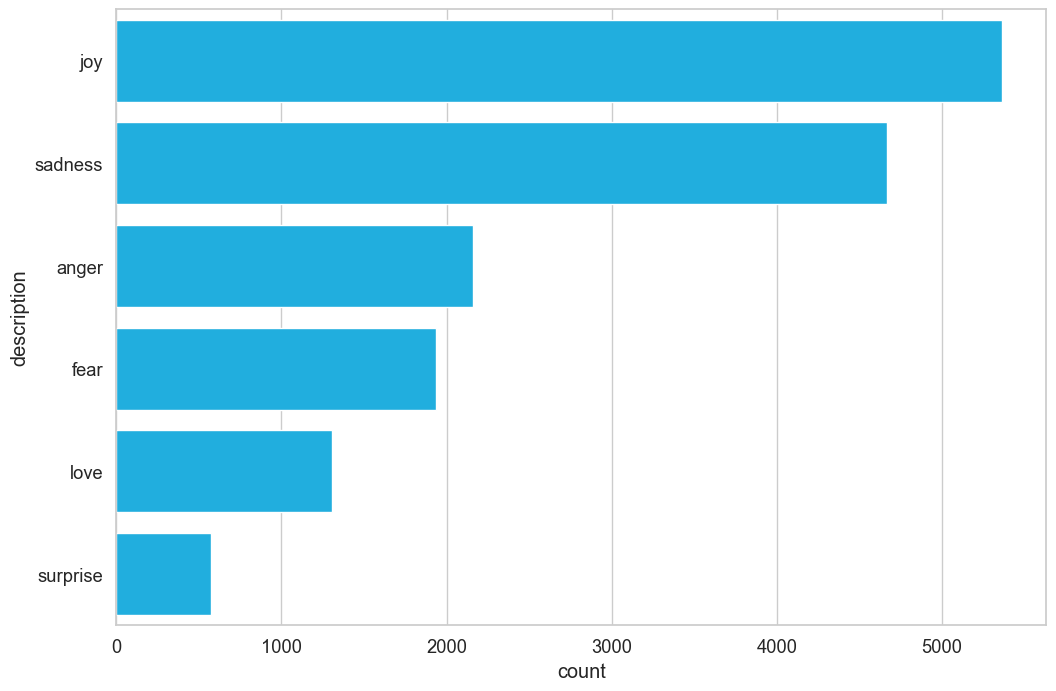

In [153]:
sns.countplot(train_df['description'],order = train_df['description'].value_counts(normalize=True).index)

About 33 percent of the tweets are joyful, followed by sad and angry tweets.

### Check for missing values in the dataset

In [154]:
# Display the first few rows to verify data loading
print("Preview of dataset:")
display(train_df.head())

# Check for total missing values per column
print("\nMissing values per column:")
print(train_df.isnull().sum())

# Check for percentage of missing values
print("\nPercentage of missing values per column:")
print((train_df.isnull().sum() / len(train_df)) * 100)

# Optionally, check if there are any completely empty rows
print("\nNumber of completely empty rows:", train_df.isnull().all(axis=1).sum())

# If there are missing values, display which rows contain them
print("\nRows containing missing values:")
display(train_df[train_df.isnull().any(axis=1)])

Preview of dataset:


,text,label,description
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger



Missing values per column:
text           0
label          0
description    0
dtype: int64

Percentage of missing values per column:
text           0.0
label          0.0
description    0.0
dtype: float64

Number of completely empty rows: 0

Rows containing missing values:


,text,label,description


### Check for duplicate rows in the training dataset

In [181]:
# Count total duplicates
duplicate_count = train_df.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)

# Display the duplicate rows (if any)
if duplicate_count > 0:
    print("\nDuplicate rows found:")
    display(train_df[train_df.duplicated()])
else:
    print("\nNo duplicate rows found.")

Number of duplicate rows: 1

Duplicate rows found:


,text,label,description,text_length,text_word_count
13846,i feel more adventurous willing to take risks ...,1,joy,62,12


### Analyzing Text Statistics
- We can now do some statistical analysis to explore the fundamental characteristics of the text data. Some of the analyses which can be helpful are:
    - Text length analysis: calculating the length of the text, and
    - word frequency analysis: calculating the word count in the form of unigrams, bigrams and trigrams.

In [155]:
train_df['text_length'] = train_df['text'].astype(str).apply(len)
train_df['text_word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))

### Tweet length analysis

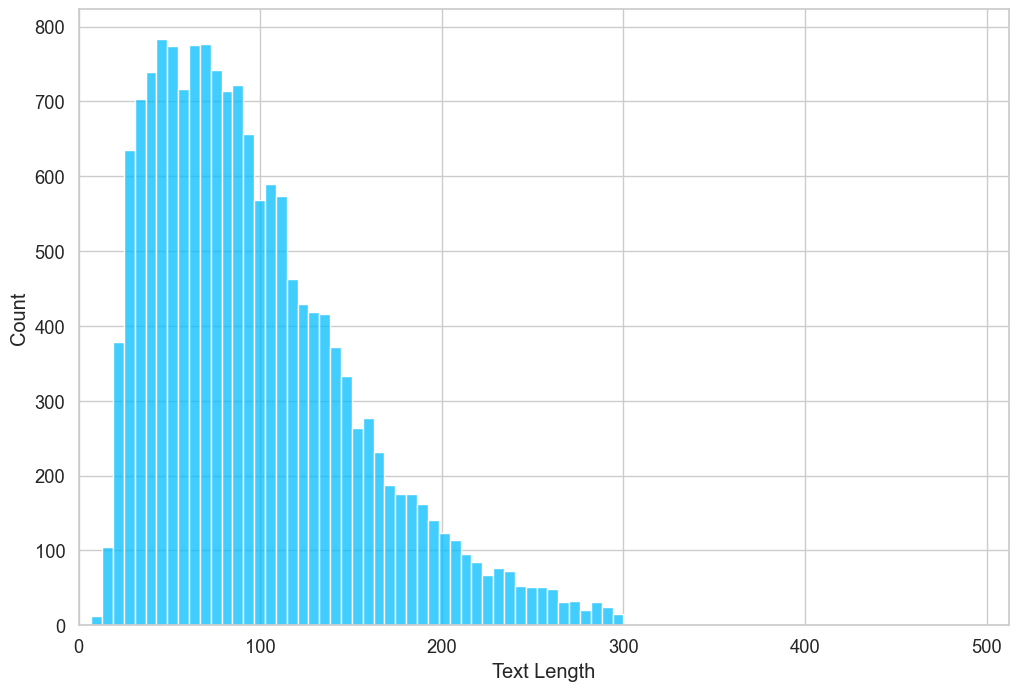

In [156]:
sns.histplot(train_df['text_length'])
plt.xlim([0, 512]);
plt.xlabel('Text Length');

The histogram above shows that the length of the tweet ranges from around 2 to 300 characters.

### Tweet word count analysis

Now let’s analyze the frequency of the words per tweet per class.

<Axes: xlabel='description', ylabel='text_word_count'>

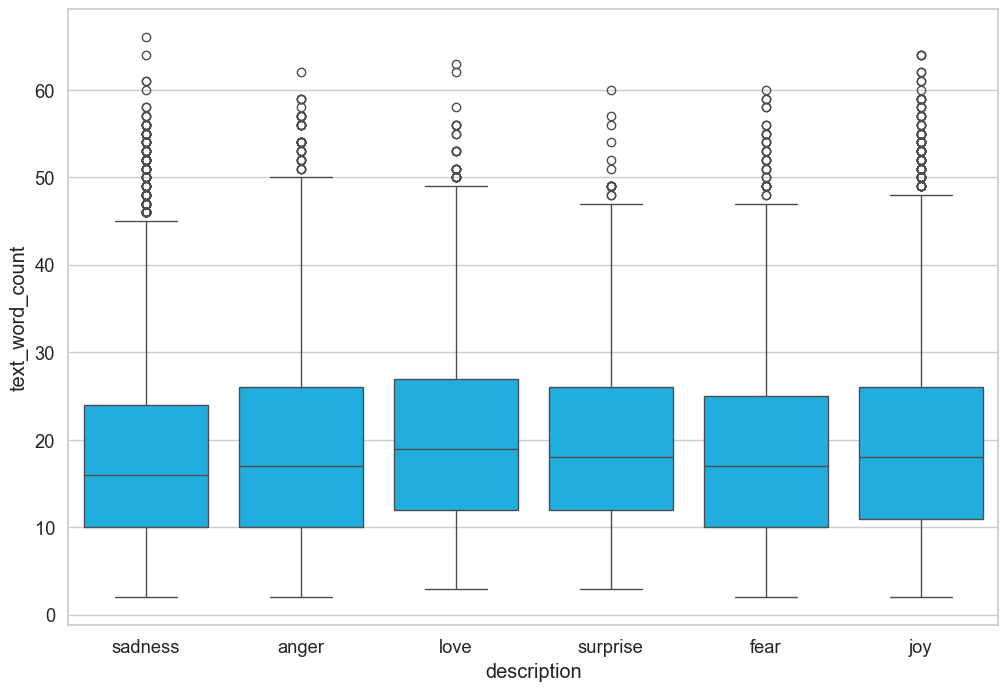

In [157]:
sns.boxplot(x="description", y="text_word_count", data=train_df)

Most of the tweets have an average of 15 words. Also, all the tweets appear to have the more or less the same length. Hence, the length of the tweet isn’t a powerful indicator of polarity.

## Distribution of top n-grams

An n-gram is a contiguous sequence of n items from a given sample of text or speech. It is also a good idea to look at various n-grams to understand which words mainly occur together. For instance, we look at the distribution of unigrams, bigrams, and trigrams across emotions- sadness, anger, and love. You can replicate the same for other categories using this code.

In [158]:
# Creating individual dataframes of different emotions
sadness = train_df[train_df['label']==0]['text']
joy = train_df[train_df['label']==1]['text']
love = train_df[train_df['label']==2]['text']
anger = train_df[train_df['label']==3]['text']
fear = train_df[train_df['label']==4]['text']
surprise = train_df[train_df['label']==5]['text']

In [159]:
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [160]:
# calculating unigrmas, bigrams and trigrams for all given emotions

sad_unigrams = get_top_n_gram(sadness.values,(1,1),7)[2:]
joy_unigrams= get_top_n_gram(joy.values,(1,1),7)[2:]
love_unigrams= get_top_n_gram(love.values,(1,1),7)[2:]
anger_unigrams= get_top_n_gram(anger.values,(1,1),7)[2:]
fear_unigrams= get_top_n_gram(fear.values,(1,1),7)[2:]
surprise_unigrams= get_top_n_gram(surprise.values,(1,1),7)[2:]



sad_bigrams = get_top_n_gram(sadness.values,(2,2),7)[2:]
joy_bigrams= get_top_n_gram(joy.values,(2,2),7)[2:]
love_bigrams= get_top_n_gram(love.values,(2,2),7)[2:]
anger_bigrams= get_top_n_gram(anger.values,(2,2),7)[2:]
fear_bigrams= get_top_n_gram(fear.values,(2,2),7)[2:]
surprise_bigrams= get_top_n_gram(surprise.values,(2,2),7)[2:]


sad_trigrams = get_top_n_gram(sadness.values,(3,3),7)[2:]
joy_trigrams= get_top_n_gram(joy.values,(3,3),7)[2:]
love_trigrams= get_top_n_gram(love.values,(3,3),7)[2:]
anger_trigrams= get_top_n_gram(anger.values,(3,3),7)[2:]
fear_trigrams= get_top_n_gram(fear.values,(3,3),7)[2:]
surprise_trigrams= get_top_n_gram(surprise.values,(3,3),7)[2:]

### Visualizing the ngrams for some of the emotions

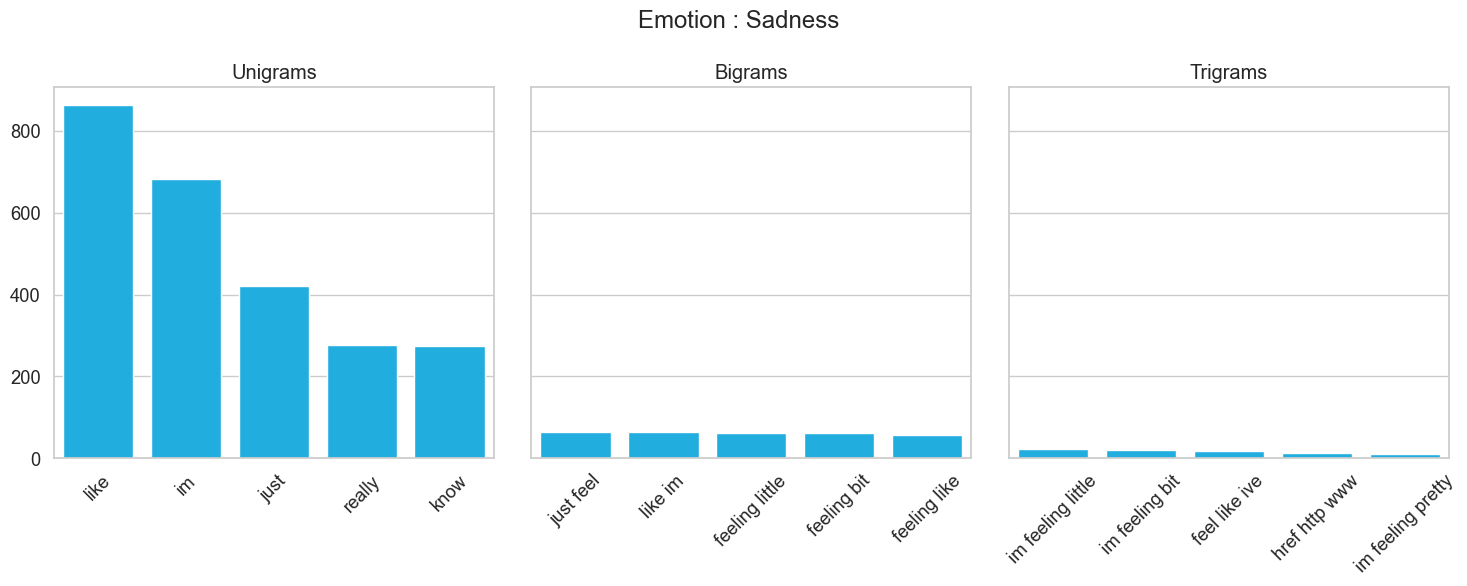

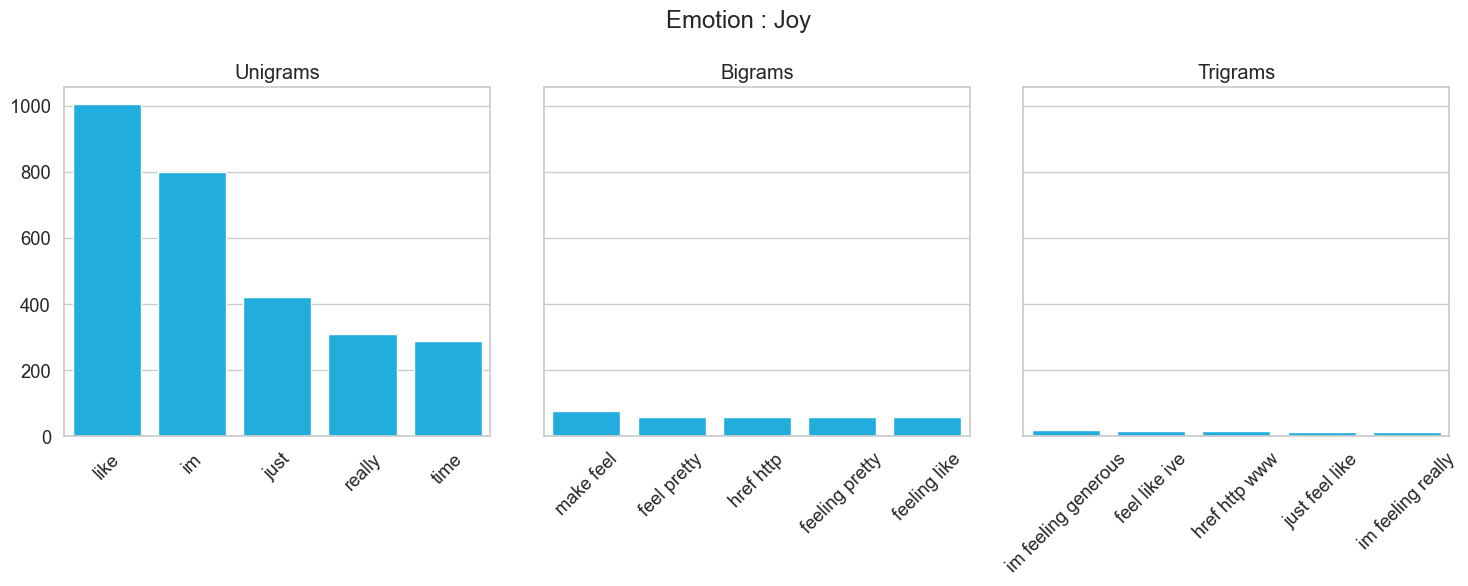

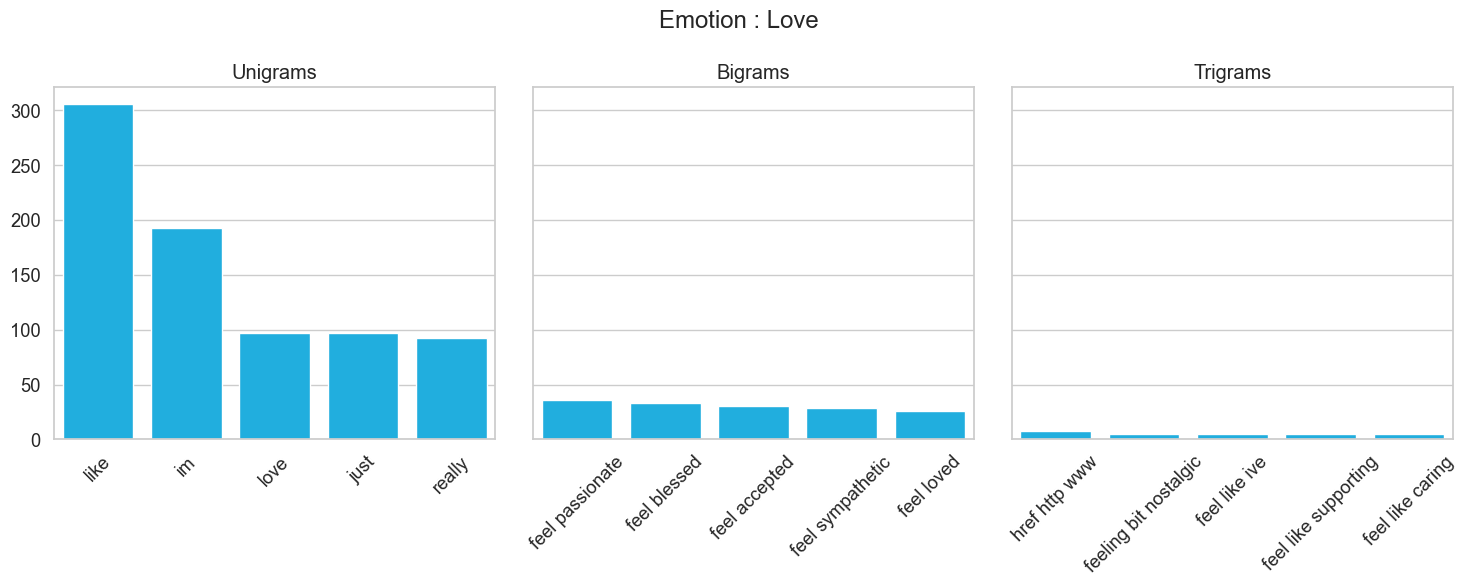

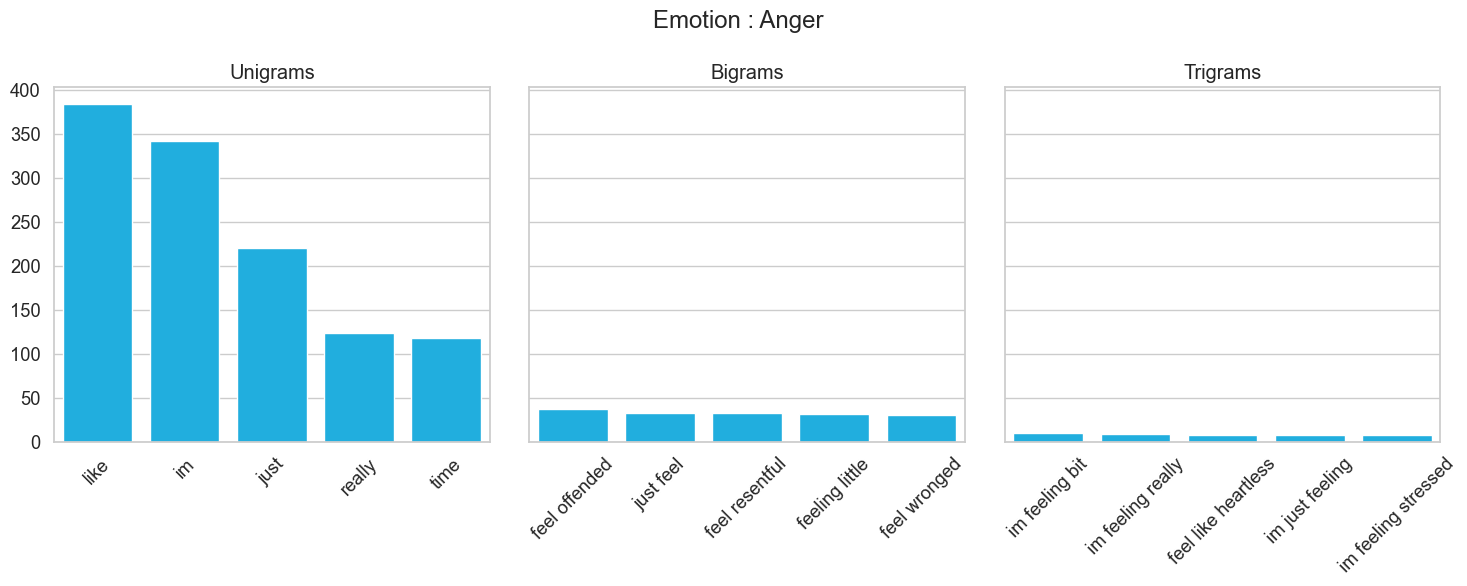

In [161]:
# helper to plot 3 ngram bars for one emotion
def plot_ngrams(title, unigrams, bigrams, trigrams, filename=None):
    fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
    fig.suptitle(f'Emotion : {title}')

    # 1) Unigrams
    sns.barplot(
        x=list(dict(unigrams).keys()),
        y=list(dict(unigrams).values()),
        ax=axes[0]
    )
    axes[0].set_title('Unigrams')
    axes[0].tick_params(axis='x', labelrotation=45)

    # 2) Bigrams
    sns.barplot(
        x=list(dict(bigrams).keys()),
        y=list(dict(bigrams).values()),
        ax=axes[1]
    )
    axes[1].set_title('Bigrams')
    axes[1].tick_params(axis='x', labelrotation=45)

    # 3) Trigrams
    sns.barplot(
        x=list(dict(trigrams).keys()),
        y=list(dict(trigrams).values()),
        ax=axes[2]
    )
    axes[2].set_title('Trigrams')
    axes[2].tick_params(axis='x', labelrotation=45)

    plt.tight_layout()
    if filename:
        fig.savefig(filename, bbox_inches='tight')
    plt.show()


# Sadness
plot_ngrams(
    title='Sadness',
    unigrams=sad_unigrams,
    bigrams=sad_bigrams,
    trigrams=sad_trigrams,
    filename='sadness.png'
)

# Joy
plot_ngrams(
    title='Joy',
    unigrams=joy_unigrams,
    bigrams=joy_bigrams,
    trigrams=joy_trigrams,
    filename='joy.png'
)

# Love
plot_ngrams(
    title='Love',
    unigrams=love_unigrams,
    bigrams=love_bigrams,
    trigrams=love_trigrams,
    filename='love.png'
)

# Anger
plot_ngrams(
    title='Anger',
    unigrams=anger_unigrams,
    bigrams=anger_bigrams,
    trigrams=anger_trigrams,
    filename='anger.png'
)


In [162]:
# === Text cleaning for classical models (SVM/Bi‑LSTM/CNN) ===
_NLTK_READY = False
def _ensure_nltk():
    global _NLTK_READY
    if _NLTK_READY:
        return
    try:
        import nltk
        for pkg in ['punkt', 'punkt_tab', 'stopwords','wordnet','omw-1.4']:
            try:
                nltk.data.find(f"tokenizers/{pkg}" if pkg in ['punkt', 'punkt_tab'] else f"corpora/{pkg}")
            except LookupError:
                nltk.download(pkg, quiet=True)
        _NLTK_READY = True
    except Exception as e:
        print('[WARN] NLTK not available or download failed — proceeding without stopwords/lemmatization:', e)

def clean_text_for_classic(text: str, do_lemma: bool = True, do_stop: bool = True) -> str:
    text = str(text).lower() #Convert to string and lowercase → makes words uniform.
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text) #Remove URLs.
    text = re.sub(r'<.*?>', ' ', text) #Remove HTML tags like <br>, <p>...</p>.
    text = re.sub(r'[@#]\w+', ' ', text)#Remove @mentions and #hashtags (common in tweets).
    text = re.sub(r"[^a-z\s']", ' ', text) #Keep only lowercase letters, spaces, and apostrophes.This strips numbers, emojis, punctuation.
    text = re.sub(r'\s+', ' ', text).strip() #Collapse multiple spaces → one space. #.strip() → remove leading/trailing spaces.
    try:
        _ensure_nltk()
        import nltk
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        from nltk.tokenize import word_tokenize
        tokens = word_tokenize(text) if text else []
        if do_stop:
            sw = set(stopwords.words('english'))
            tokens = [t for t in tokens if t not in sw and len(t) > 1]
        if do_lemma:
            lemm = WordNetLemmatizer()
            tokens = [lemm.lemmatize(t) for t in tokens]
        return ' '.join(tokens)
    except Exception as e:
        print("CLEANING ERROR:", e)
        return text

def apply_cleaning(df: pd.DataFrame, text_col: str = 'text') -> pd.DataFrame:
    df = df.copy()
    df['clean_text'] = df[text_col].astype(str).apply(clean_text_for_classic)
    return df

train_c = apply_cleaning(train_df, 'text')
val_c   = apply_cleaning(val_df, 'text')
test_c  = apply_cleaning(test_df, 'text')
display(train_c[['text','clean_text','label']].head())


,text,clean_text,label
0,i didnt feel humiliated,didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,go feeling hopeless damned hopeful around some...,0
2,im grabbing a minute to post i feel greedy wrong,im grabbing minute post feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,ever feeling nostalgic fireplace know still pr...,2
4,i am feeling grouchy,feeling grouchy,3


In [163]:
# === Metrics, reports, and plotting ===
import matplotlib.pyplot as plt

def compute_metrics(y_true, y_pred) -> Dict[str, float]:
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro')
    }

def print_report(y_true, y_pred, labels):
    print('Confusion Matrix:')
    print(confusion_matrix(y_true, y_pred, labels=labels))
    print('\nClassification Report:')
    print(classification_report(y_true, y_pred, digits=4))

def plot_confusion_matrix_basic(y_true, y_pred, labels, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center')
    plt.show()
    return cm
print('Metrics helpers ready')


Metrics helpers ready


[Model] Linear SVM + TF‑IDF
Validation: {'accuracy': 0.9115, 'f1_macro': 0.8818722621965227}
Test: {'accuracy': 0.901, 'f1_macro': 0.8605891135292909, 'y_true': array([0, 0, 0, ..., 1, 1, 4]), 'y_pred': array([0, 0, 0, ..., 1, 1, 4])}


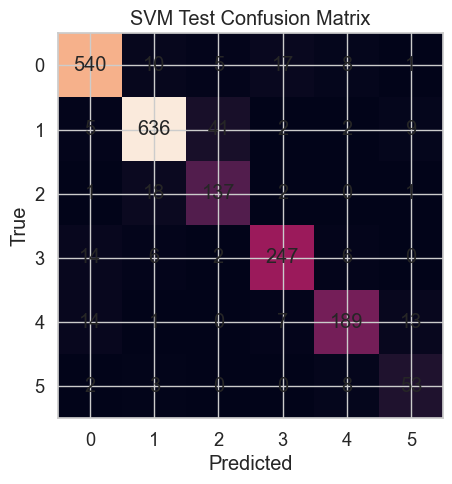

In [176]:
# === 1) SVM + TF‑IDF (baseline) ===
svm_results = None
if 'svm' in RUN_MODELS:
    print('[Model] Linear SVM + TF‑IDF')
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95, sublinear_tf=True, max_features=80000)),
        ('svm', LinearSVC(class_weight='balanced', random_state=42))
    ])
    Xtr, ytr = train_c['clean_text'].tolist(), train_c['label'].values
    Xva, yva = val_c['clean_text'].tolist(),   val_c['label'].values
    Xte, yte = test_c['clean_text'].tolist(),  test_c['label'].values
    pipe.fit(Xtr, ytr)
    val_pred = pipe.predict(Xva)
    test_pred = pipe.predict(Xte)
    svm_results = {
        'val': compute_metrics(yva, val_pred),
        'test': {
            **compute_metrics(yte, test_pred),
            'y_true': yte,          
            'y_pred': test_pred     
        }
    }
    print('Validation:', svm_results['val'])
    print('Test:', svm_results['test'])
    pd.Series(val_pred, name='svm_val_pred').to_csv(os.path.join(OUTPUT_DIR, 'svm_val_pred.csv'), index=False)
    pd.Series(test_pred, name='svm_test_pred').to_csv(os.path.join(OUTPUT_DIR, 'svm_test_pred.csv'), index=False)
    labels_sorted = sorted(np.unique(np.concatenate([ytr, yva, yte])))
    _ = plot_confusion_matrix_basic(yte, test_pred, labels_sorted, title='SVM Test Confusion Matrix')
else:
    print('Skipping SVM')


In [165]:
# === Shared helpers for Keras models (Bi‑LSTM / CNN) ===
def build_keras_tokenizer(texts: List[str], num_words: int = 30000):
    from tensorflow.keras.preprocessing.text import Tokenizer
    tok = Tokenizer(num_words=num_words, oov_token='<OOV>')
    tok.fit_on_texts(texts)
    return tok

def texts_to_padded(tok, texts: List[str], max_len: int = 200):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    seqs = tok.texts_to_sequences(texts)
    X = pad_sequences(seqs, maxlen=max_len, padding='post', truncating='post')
    return X

def compute_class_weights(y: np.ndarray) -> Dict[int, float]:
    classes = np.unique(y)
    cw = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    return {int(c): float(w) for c, w in zip(classes, cw)}
print('Keras helpers ready')


Keras helpers ready


[Model] Bi‑LSTM
Epoch 1/6
250/250 - 41s - loss: 1.0110 - accuracy: 0.6417 - val_loss: 0.2623 - val_accuracy: 0.9185 - 41s/epoch - 165ms/step
Epoch 2/6
250/250 - 41s - loss: 0.1780 - accuracy: 0.9366 - val_loss: 0.2154 - val_accuracy: 0.9220 - 41s/epoch - 165ms/step
Epoch 3/6
250/250 - 41s - loss: 0.0946 - accuracy: 0.9630 - val_loss: 0.2384 - val_accuracy: 0.9200 - 41s/epoch - 164ms/step
Epoch 4/6
250/250 - 48s - loss: 0.0709 - accuracy: 0.9733 - val_loss: 0.3062 - val_accuracy: 0.9130 - 48s/epoch - 191ms/step
Validation: {'accuracy': 0.922, 'f1_macro': 0.895433800929058}
Test: {'accuracy': 0.9145, 'f1_macro': 0.87456044715511, 'y_true': array([0, 0, 0, ..., 1, 1, 4]), 'y_pred': array([0, 0, 0, ..., 1, 1, 5])}


/opt/homebrew/Caskroom/miniconda/base/envs/mlcourse/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


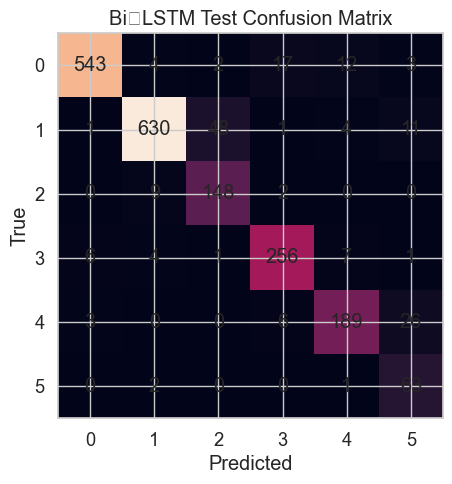

In [177]:
# === 2) Bi‑LSTM (Keras) ===
bilstm_results = None
if 'bilstm' in RUN_MODELS:
    import tensorflow as tf
    from tensorflow.keras import layers, Model
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
    print('[Model] Bi‑LSTM')
    Xtr_texts = train_c['clean_text'].tolist(); ytr = train_c['label'].values
    Xva_texts = val_c['clean_text'].tolist();   yva = val_c['label'].values
    Xte_texts = test_c['clean_text'].tolist();  yte = test_c['label'].values
    num_classes = int(max(ytr.max(), yva.max(), yte.max()) + 1)

    tok = build_keras_tokenizer(Xtr_texts + Xva_texts + Xte_texts, num_words=30000)
    Xtr = texts_to_padded(tok, Xtr_texts, max_len=200)
    Xva = texts_to_padded(tok, Xva_texts, max_len=200)
    Xte = texts_to_padded(tok, Xte_texts, max_len=200)

    inputs = layers.Input(shape=(200,), dtype='int32')
    x = layers.Embedding(30000, 128, mask_zero=True)(inputs)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    ckpt_path = os.path.join(OUTPUT_DIR, 'bilstm.best.keras')
    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True),
        ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True)
    ]
    class_weights = compute_class_weights(ytr)

    model.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=6, batch_size=64,
              callbacks=callbacks, class_weight=class_weights, verbose=2)

    val_pred = np.argmax(model.predict(Xva, verbose=0), axis=1)
    test_pred = np.argmax(model.predict(Xte, verbose=0), axis=1)
    bilstm_results = {
        'val': compute_metrics(yva, val_pred), 
        'test': {
            **compute_metrics(yte, test_pred),
            'y_true': yte,         
            'y_pred': test_pred     
        }
        }
    print('Validation:', bilstm_results['val'])
    print('Test:', bilstm_results['test'])
    pd.Series(val_pred, name='bilstm_val_pred').to_csv(os.path.join(OUTPUT_DIR, 'bilstm_val_pred.csv'), index=False)
    pd.Series(test_pred, name='bilstm_test_pred').to_csv(os.path.join(OUTPUT_DIR, 'bilstm_test_pred.csv'), index=False)
    labels_sorted = sorted(np.unique(np.concatenate([ytr, yva, yte])))
    _ = plot_confusion_matrix_basic(yte, test_pred, labels_sorted, title='Bi‑LSTM Test Confusion Matrix')
else:
    print('Skipping Bi‑LSTM')


[Model] Text CNN
Epoch 1/6
250/250 - 15s - loss: 1.0333 - accuracy: 0.5772 - val_loss: 0.2498 - val_accuracy: 0.9155 - 15s/epoch - 59ms/step
Epoch 2/6
250/250 - 14s - loss: 0.1757 - accuracy: 0.9333 - val_loss: 0.2063 - val_accuracy: 0.9190 - 14s/epoch - 57ms/step
Epoch 3/6
250/250 - 14s - loss: 0.0843 - accuracy: 0.9661 - val_loss: 0.2270 - val_accuracy: 0.9240 - 14s/epoch - 58ms/step
Epoch 4/6
250/250 - 15s - loss: 0.0570 - accuracy: 0.9786 - val_loss: 0.2714 - val_accuracy: 0.9215 - 15s/epoch - 62ms/step
Epoch 5/6
250/250 - 16s - loss: 0.0385 - accuracy: 0.9868 - val_loss: 0.2544 - val_accuracy: 0.9195 - 16s/epoch - 63ms/step
Validation: {'accuracy': 0.924, 'f1_macro': 0.899844918318649}
Test: {'accuracy': 0.9175, 'f1_macro': 0.8799834418993241, 'y_true': array([0, 0, 0, ..., 1, 1, 4]), 'y_pred': array([0, 0, 0, ..., 1, 1, 5])}


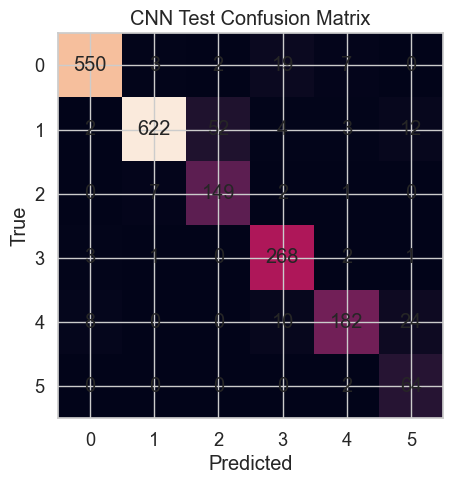

In [178]:
# === 3) Text CNN (Keras) ===
cnn_results = None
if 'cnn' in RUN_MODELS:
    import tensorflow as tf
    from tensorflow.keras import layers, Model
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
    print('[Model] Text CNN')
    Xtr_texts = train_c['clean_text'].tolist(); ytr = train_c['label'].values
    Xva_texts = val_c['clean_text'].tolist();   yva = val_c['label'].values
    Xte_texts = test_c['clean_text'].tolist();  yte = test_c['label'].values
    num_classes = int(max(ytr.max(), yva.max(), yte.max()) + 1)

    tok = build_keras_tokenizer(Xtr_texts + Xva_texts + Xte_texts, num_words=30000)
    Xtr = texts_to_padded(tok, Xtr_texts, max_len=200)
    Xva = texts_to_padded(tok, Xva_texts, max_len=200)
    Xte = texts_to_padded(tok, Xte_texts, max_len=200)

    inputs = layers.Input(shape=(200,), dtype='int32')
    x = layers.Embedding(30000, 128)(inputs)
    convs = []
    for k in [3,4,5]:
        c = layers.Conv1D(128, kernel_size=k, activation='relu', padding='valid')(x)
        c = layers.GlobalMaxPooling1D()(c)
        convs.append(c)
    x = layers.concatenate(convs)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    ckpt_path = os.path.join(OUTPUT_DIR, 'cnn.best.keras')
    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True),
        ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True)
    ]
    class_weights = compute_class_weights(ytr)

    model.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=6, batch_size=64,
              callbacks=callbacks, class_weight=class_weights, verbose=2)

    val_pred = np.argmax(model.predict(Xva, verbose=0), axis=1)
    test_pred = np.argmax(model.predict(Xte, verbose=0), axis=1)
    cnn_results = {
        'val': compute_metrics(yva, val_pred), 
        'test': {
            **compute_metrics(yte, test_pred),
            'y_true': yte,          
            'y_pred': test_pred    
        }
        }
    print('Validation:', cnn_results['val'])
    print('Test:', cnn_results['test'])
    pd.Series(val_pred, name='cnn_val_pred').to_csv(os.path.join(OUTPUT_DIR, 'cnn_val_pred.csv'), index=False)
    pd.Series(test_pred, name='cnn_test_pred').to_csv(os.path.join(OUTPUT_DIR, 'cnn_test_pred.csv'), index=False)
    labels_sorted = sorted(np.unique(np.concatenate([ytr, yva, yte])))
    _ = plot_confusion_matrix_basic(yte, test_pred, labels_sorted, title='CNN Test Confusion Matrix')
else:
    print('Skipping CNN')

In [168]:
!pip install -U transformers accelerate datasets --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [169]:
# === HuggingFace transformer fine-tuning helpers (DistilBERT / RoBERTa) ===
import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch device:", device)

# We'll assume labels in dataframes are already numeric {0..num_classes-1}
unique_labels = sorted(train_df["label"].unique().tolist())
num_classes = len(unique_labels)
id2label = {int(i): str(i) for i in unique_labels}
label2id = {v: k for k, v in id2label.items()}

class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len: int = 200):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=max_len,
            return_tensors="pt"
        )
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

def build_hf_datasets(tokenizer, train_df, val_df, test_df, text_col='text', label_col='label', max_len=200):
    train_ds = EmotionDataset(
        train_df[text_col].tolist(),
        train_df[label_col].tolist(),
        tokenizer,
        max_len=max_len
    )
    val_ds = EmotionDataset(
        val_df[text_col].tolist(),
        val_df[label_col].tolist(),
        tokenizer,
        max_len=max_len
    )
    test_ds = EmotionDataset(
        test_df[text_col].tolist(),
        test_df[label_col].tolist(),
        tokenizer,
        max_len=max_len
    )
    return train_ds, val_ds, test_ds

def hf_compute_metrics(eval_pred):
    """
    This is used by Trainer during eval.
    Returns accuracy + macro F1 so Trainer can pick best model.
    """
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

def eval_on_split(trainer, dataset, true_labels):
    """
    Run trainer.predict(dataset), then compute our notebook metrics + confusion matrix plot.
    """
    pred_output = trainer.predict(dataset)
    y_pred = np.argmax(pred_output.predictions, axis=1)

    # compute_metrics() is already defined earlier in your notebook
    metrics_basic = compute_metrics(true_labels, y_pred)

    labels_sorted = sorted(np.unique(np.concatenate([true_labels, y_pred])))
    _ = plot_confusion_matrix_basic(true_labels, y_pred, labels_sorted, title='Transformer Confusion Matrix')

    return metrics_basic, y_pred


Torch device: cpu


[Model] DistilBERT (regularized)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Caskroom/miniconda/base/envs/mlcourse/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.223900,0.196831,0.933500,0.909209
2,0.132800,0.144751,0.940500,0.914129
3,0.081100,0.153610,0.944000,0.919808
4,0.071900,0.168962,0.945500,0.922264


/opt/homebrew/Caskroom/miniconda/base/envs/mlcourse/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniconda/base/envs/mlcourse/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniconda/base/envs/mlcourse/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniconda/base/envs/mlcourse/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device

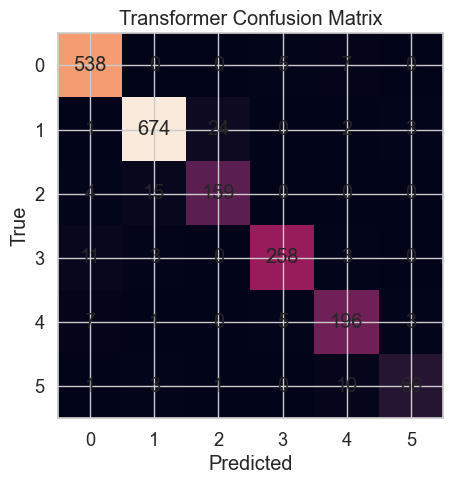

/opt/homebrew/Caskroom/miniconda/base/envs/mlcourse/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


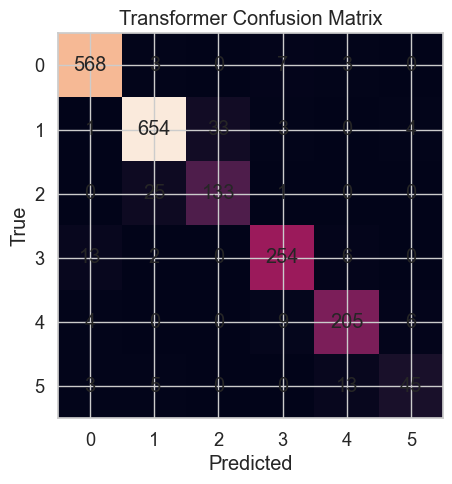

DistilBERT Validation: {'accuracy': 0.9455, 'f1_macro': 0.9222642214869392}
DistilBERT Test: {'accuracy': 0.9295, 'f1_macro': 0.8854499563286379, 'y_true': array([0, 0, 0, ..., 1, 1, 4]), 'y_pred': array([0, 0, 0, ..., 1, 1, 4])}


In [170]:
from transformers import EarlyStoppingCallback

distilbert_results = None
if 'distilbert' in RUN_MODELS:
    print('[Model] DistilBERT (regularized)')

    model_name = "distilbert-base-uncased"

    tokenizer_distil = AutoTokenizer.from_pretrained(model_name)
    train_ds, val_ds, test_ds = build_hf_datasets(
        tokenizer_distil,
        train_df,
        val_df,
        test_df,
        text_col='text',
        label_col='label',
        max_len=200,
    )

    model_distil = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_classes,
        id2label=id2label,
        label2id=label2id,
    )

    distil_output_dir = os.path.join(OUTPUT_DIR, "distilbert_ckpt")

    training_args_distil = TrainingArguments(
        output_dir=distil_output_dir,

        # evaluate & save every epoch, keep best model by macro F1
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1_macro",
        greater_is_better=True,
        save_total_limit=2,

        # regularization
        learning_rate=3e-5,
        weight_decay=0.01,
        warmup_ratio=0.05,
        num_train_epochs=4,
        max_grad_norm=1.0,

        # batch sizes
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,

        # logging / misc
        logging_steps=50,
        report_to=[],
    )


    trainer_distil = Trainer(
        model=model_distil,
        args=training_args_distil,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        processing_class=tokenizer_distil,
        compute_metrics=hf_compute_metrics,
        callbacks=[EarlyStoppingCallback(
            early_stopping_patience=2,
            early_stopping_threshold=0.0
        )]
    )


    trainer_distil.train()

    #Evaluate on val & test
    yva = val_df['label'].values
    yte = test_df['label'].values

    val_metrics_distil, val_pred_distil = eval_on_split(trainer_distil, val_ds, yva)
    test_metrics_distil, test_pred_distil = eval_on_split(trainer_distil, test_ds, yte)

    distilbert_results = {
        'val':  val_metrics_distil,
        'test': {
            **test_metrics_distil,
            'y_true': yte,
            'y_pred': test_pred_distil
        }
    }

    print('DistilBERT Validation:', distilbert_results['val'])
    print('DistilBERT Test:', distilbert_results['test'])

    # save predictions for analysis / confusion matrices by class
    pd.Series(val_pred_distil,  name='distilbert_val_pred').to_csv(
        os.path.join(OUTPUT_DIR, 'distilbert_val_pred.csv'),
        index=False
    )
    pd.Series(test_pred_distil, name='distilbert_test_pred').to_csv(
        os.path.join(OUTPUT_DIR, 'distilbert_test_pred.csv'),
        index=False
    )

else:
    print('Skipping DistilBERT')

[Model] RoBERTa (transformers Trainer)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/Caskroom/miniconda/base/envs/mlcourse/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.287000,0.185328,0.930500,0.906733
2,0.159100,0.158153,0.936000,0.907101
3,0.112900,0.137571,0.939500,0.915503


/opt/homebrew/Caskroom/miniconda/base/envs/mlcourse/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniconda/base/envs/mlcourse/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniconda/base/envs/mlcourse/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


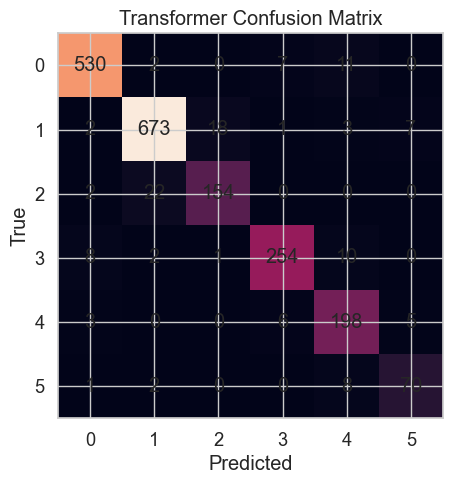

/opt/homebrew/Caskroom/miniconda/base/envs/mlcourse/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


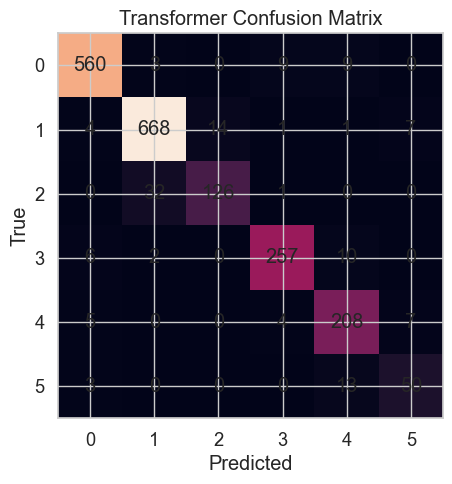

RoBERTa Validation: {'accuracy': 0.9395, 'f1_macro': 0.9155033108363791}
RoBERTa Test: {'accuracy': 0.9345, 'f1_macro': 0.8944951230536241, 'y_true': array([0, 0, 0, ..., 1, 1, 4]), 'y_pred': array([0, 0, 0, ..., 1, 1, 4])}


In [171]:
roberta_results = None
if 'roberta' in RUN_MODELS:
    print('[Model] RoBERTa (transformers Trainer)')

    model_name = "roberta-base"

    tokenizer_rob = AutoTokenizer.from_pretrained(model_name)
    train_ds_r, val_ds_r, test_ds_r = build_hf_datasets(
        tokenizer_rob,
        train_df,
        val_df,
        test_df,
        text_col='text',
        label_col='label',
        max_len=200,
    )

    model_rob = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_classes,
        id2label=id2label,
        label2id=label2id,
    )

    roberta_output_dir = os.path.join(OUTPUT_DIR, "roberta_ckpt")

    training_args_rob = TrainingArguments(
        output_dir=roberta_output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1_macro",
        greater_is_better=True,
        save_total_limit=2,

        learning_rate=2e-5,             # slightly lower lr is common for RoBERTa
        weight_decay=0.01,
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,

        logging_steps=50,
        report_to=[],
    )

    trainer_rob = Trainer(
        model=model_rob,
        args=training_args_rob,
        train_dataset=train_ds_r,
        eval_dataset=val_ds_r,
        processing_class=tokenizer_rob,
        compute_metrics=hf_compute_metrics,
    )

    trainer_rob.train()

    yva = val_df['label'].values
    yte = test_df['label'].values

    val_metrics_rob, val_pred_rob = eval_on_split(trainer_rob, val_ds_r, yva)
    test_metrics_rob, test_pred_rob = eval_on_split(trainer_rob, test_ds_r, yte)

    roberta_results = {
        'val':  val_metrics_rob,
        'test': {
            **test_metrics_rob,
            'y_true': yte,
            'y_pred': test_pred_rob
        }
    }

    print('RoBERTa Validation:', roberta_results['val'])
    print('RoBERTa Test:', roberta_results['test'])

    pd.Series(val_pred_rob,  name='roberta_val_pred').to_csv(
        os.path.join(OUTPUT_DIR, 'roberta_val_pred.csv'),
        index=False
    )
    pd.Series(test_pred_rob, name='roberta_test_pred').to_csv(
        os.path.join(OUTPUT_DIR, 'roberta_test_pred.csv'),
        index=False
    )

else:
    print('Skipping RoBERTa')


In [172]:
# === Compare all results ===
rows = []
def add_row(name, res):
    if res is None: return
    rows.append({
        'model': name,
        'val_accuracy': res['val']['accuracy'],
        'val_f1_macro': res['val']['f1_macro'],
        'test_accuracy': res['test']['accuracy'],
        'test_f1_macro': res['test']['f1_macro']
    })

add_row('svm_tfidf', svm_results)
add_row('bilstm', bilstm_results)
add_row('cnn', cnn_results)
add_row('distilbert', distilbert_results)
add_row('roberta', roberta_results)

if rows:
    metrics_df = pd.DataFrame(rows).sort_values(by=['test_f1_macro','test_accuracy'], ascending=False)
    display(metrics_df)
    metrics_df.to_csv(os.path.join(OUTPUT_DIR, 'metrics_summary.csv'), index=False)
    print('Saved metrics to', os.path.join(OUTPUT_DIR, 'metrics_summary.csv'))
else:
    print('No models were run — check RUN_MODELS settings.')


,model,val_accuracy,val_f1_macro,test_accuracy,test_f1_macro
4,roberta,0.9395,0.915503,0.9345,0.894495
3,distilbert,0.9455,0.922264,0.9295,0.885450
2,cnn,0.9240,0.899845,0.9175,0.879983
1,bilstm,0.9220,0.895434,0.9145,0.874560
0,svm_tfidf,0.9115,0.881872,0.9010,0.860589


Saved metrics to outputs/metrics_summary.csv


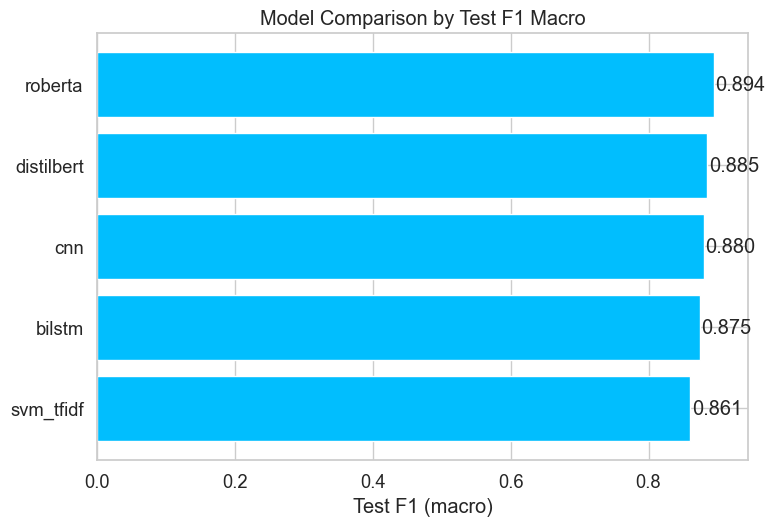

In [173]:
import matplotlib.pyplot as plt

# make sure metrics_df exists from your previous code
if not rows:
    print("No models were run — nothing to plot.")
else:
    # work on a copy and sort by test_f1_macro
    plot_df = metrics_df.sort_values(by="test_f1_macro", ascending=True)  # ascending=True for nicer hbar

    models = plot_df["model"].tolist()
    scores = plot_df["test_f1_macro"].tolist()

    plt.figure(figsize=(8, 4 + 0.3 * len(models)))
    bars = plt.barh(models, scores)

    # add value labels
    for bar, score in zip(bars, scores):
        plt.text(
            score + 0.002,               # a tiny offset to the right
            bar.get_y() + bar.get_height() / 2,
            f"{score:.3f}",
            va="center"
        )

    plt.xlabel("Test F1 (macro)")
    plt.title("Model Comparison by Test F1 Macro")
    plt.xlim(0, max(scores) + 0.05)
    plt.tight_layout()
    plt.show()


In [174]:
plt.savefig(os.path.join(OUTPUT_DIR, "metrics_f1_barplot.png"), dpi=300)


<Figure size 1200x800 with 0 Axes>

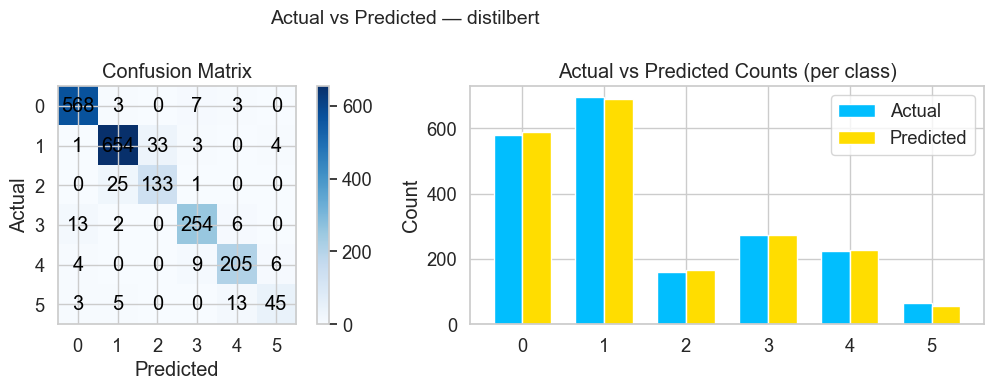

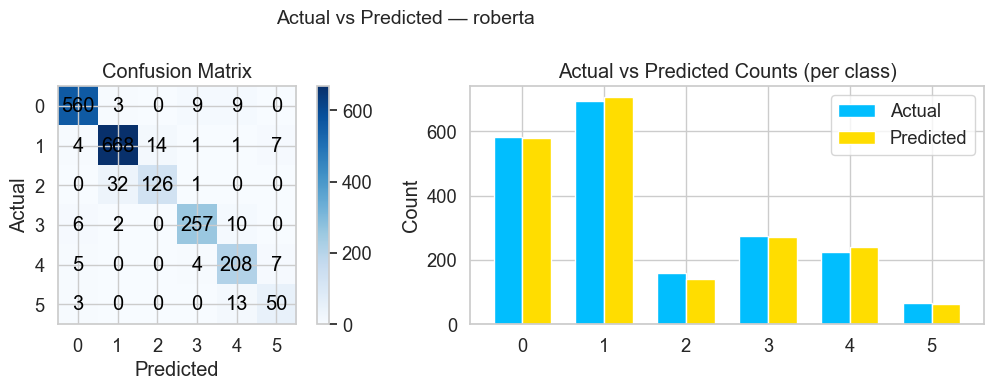

In [179]:
# collect all model result dicts here
all_model_results = {
    "distilbert": distilbert_results,
    "roberta": roberta_results,
}

for model_name, res in all_model_results.items():
    # skip models that didn't run
    if res is None:
        continue
    test_part = res.get("test", {})
    y_true = test_part.get("y_true", None)
    y_pred = test_part.get("y_pred", None)
    if y_true is None or y_pred is None:
        # nothing to plot for this model
        continue

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # figure out labels from the data
    labels = np.unique(np.concatenate([y_true, y_pred]))
    labels = np.sort(labels)

    # --- 1) Confusion matrix ---
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # --- 2) Actual vs predicted counts (differences) ---
    actual_counts = pd.Series(y_true).value_counts().sort_index()
    pred_counts = pd.Series(y_pred).value_counts().sort_index()

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"Actual vs Predicted — {model_name}", fontsize=14)

    # LEFT: confusion matrix
    ax = axes[0]
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # RIGHT: actual vs predicted bar chart
    ax2 = axes[1]
    x = np.arange(len(labels))
    width = 0.35
    ax2.bar(x - width/2, [actual_counts.get(l, 0) for l in labels], width, label="Actual")
    ax2.bar(x + width/2, [pred_counts.get(l, 0) for l in labels], width, label="Predicted")
    ax2.set_title("Actual vs Predicted Counts (per class)")
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels)
    ax2.set_ylabel("Count")
    ax2.legend()

    plt.tight_layout()
    plt.show()



=== svm_tfidf ===


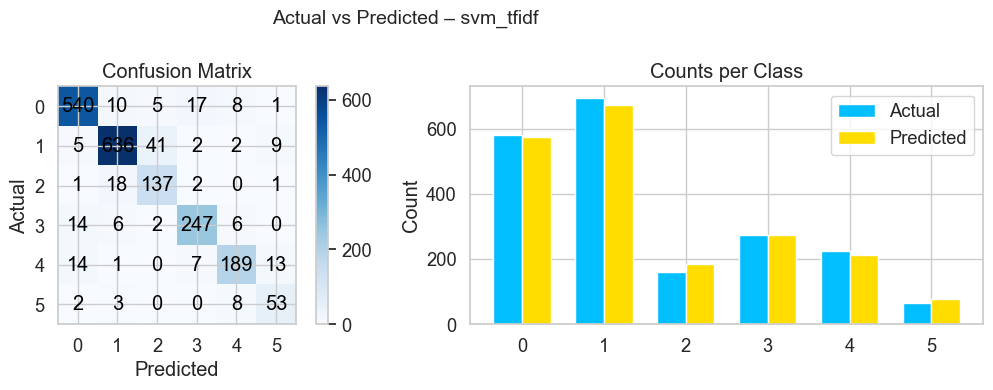


=== bilstm ===


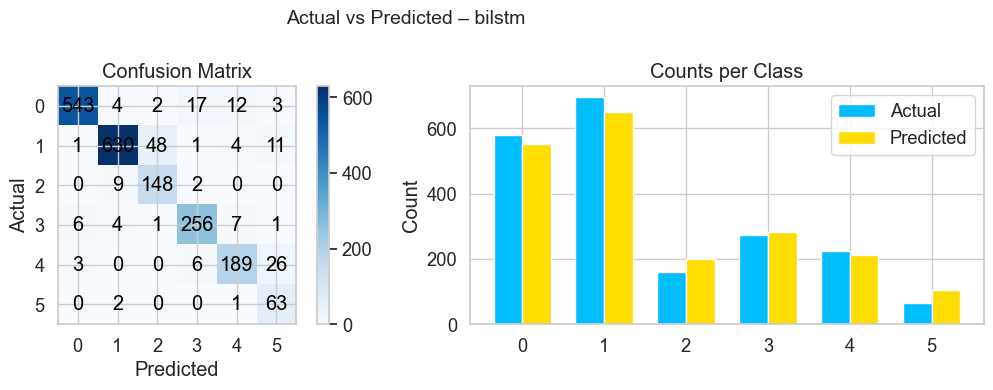


=== cnn ===


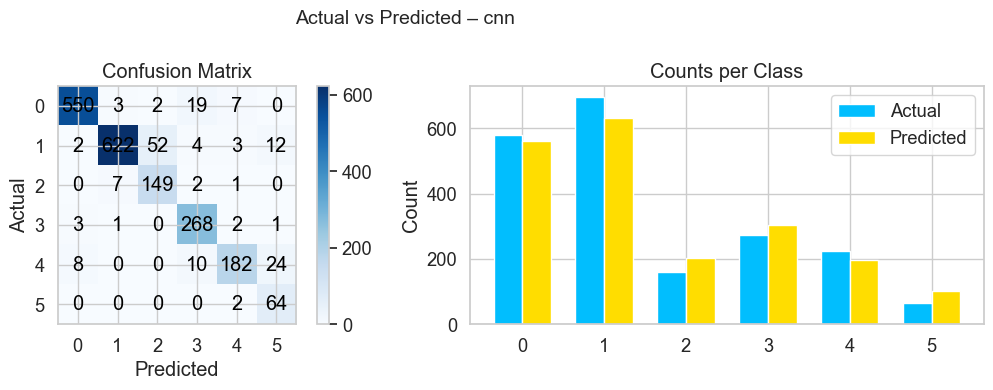

In [180]:
model_dict = {
    "svm_tfidf": svm_results,
    "bilstm": bilstm_results,
    "cnn": cnn_results,
}

for model_name, res in model_dict.items():
    print(f"\n=== {model_name} ===")
    if res is None or "test" not in res:
        print(" -> model not run, skipping")
        continue

    y_true = res["test"].get("y_true", None)
    y_pred = res["test"].get("y_pred", None)

    if y_true is None or y_pred is None:
        print(" -> no y_true/y_pred stored, skipping")
        continue

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # labels present in this test set
    labels = np.unique(np.concatenate([y_true, y_pred]))
    labels = np.sort(labels)

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # counts for actual vs predicted
    actual_counts = pd.Series(y_true).value_counts().sort_index()
    pred_counts   = pd.Series(y_pred).value_counts().sort_index()

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"Actual vs Predicted – {model_name}", fontsize=14)

    # LEFT: confusion matrix
    ax = axes[0]
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # RIGHT: actual vs predicted bar chart
    ax2 = axes[1]
    x = np.arange(len(labels))
    width = 0.35
    ax2.bar(x - width/2, [actual_counts.get(l, 0) for l in labels], width, label="Actual")
    ax2.bar(x + width/2, [pred_counts.get(l, 0) for l in labels], width, label="Predicted")
    ax2.set_title("Counts per Class")
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels)
    ax2.set_ylabel("Count")
    ax2.legend()

    plt.tight_layout()
    plt.show()


In [182]:
# collect all models in one dict
all_models = {
    "svm_tfidf": svm_results,
    "bilstm": bilstm_results,
    "cnn": cnn_results,
    "distilbert": distilbert_results,
    "roberta": roberta_results,
}

per_label_scores = {}   # {label: {model_name: score}}

for model_name, res in all_models.items():
    if res is None:
        continue
    test_part = res.get("test", {})
    y_true = test_part.get("y_true")
    y_pred = test_part.get("y_pred")
    if y_true is None or y_pred is None:
        continue

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # make sure we see all labels that appeared for this model
    labels = np.unique(np.concatenate([y_true, y_pred]))

    for lbl in labels:
        mask = (y_true == lbl)
        total = mask.sum()
        if total == 0:
            continue
        correct = (y_pred[mask] == lbl).sum()
        acc = correct / total  # per-label accuracy (recall)
        per_label_scores.setdefault(lbl, {})[model_name] = acc

# turn into a DataFrame for easy viewing
df_scores = pd.DataFrame(per_label_scores).T  # rows = labels, cols = models
print("Per-label accuracy (rows = labels, cols = models):")
print(df_scores)

# now find the best model for each label
best_models = df_scores.idxmax(axis=1)
best_scores = df_scores.max(axis=1)

print("\nBest model per label:")
for lbl in df_scores.index:
    print(f"Label {lbl}: {best_models[lbl]} (acc={best_scores[lbl]:.3f})")


Per-label accuracy (rows = labels, cols = models):
   svm_tfidf    bilstm       cnn  distilbert   roberta
0   0.929432  0.934596  0.946644    0.977625  0.963855
1   0.915108  0.906475  0.894964    0.941007  0.961151
2   0.861635  0.930818  0.937107    0.836478  0.792453
3   0.898182  0.930909  0.974545    0.923636  0.934545
4   0.843750  0.843750  0.812500    0.915179  0.928571
5   0.803030  0.954545  0.969697    0.681818  0.757576

Best model per label:
Label 0: distilbert (acc=0.978)
Label 1: roberta (acc=0.961)
Label 2: cnn (acc=0.937)
Label 3: cnn (acc=0.975)
Label 4: roberta (acc=0.929)
Label 5: cnn (acc=0.970)


In [185]:
# df_scores: rows = labels, cols = models
labels = df_scores.index.astype(str)
models = df_scores.columns

x = np.arange(len(labels))  # label positions
width = 0.12  # bar width (shrink if you have many models)


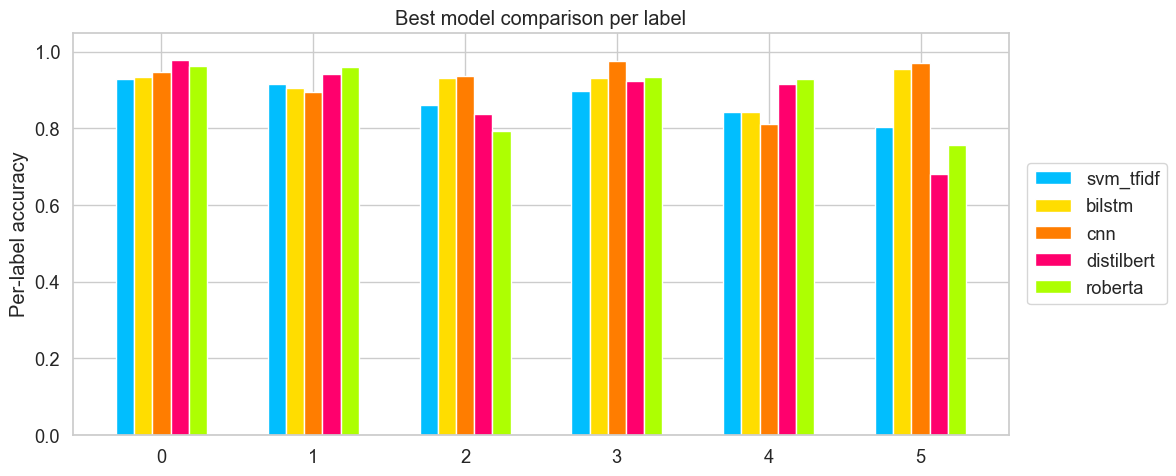

In [186]:
fig, ax = plt.subplots(figsize=(12, 5))

for i, model in enumerate(models):
    ax.bar(
        x + i*width,
        df_scores[model].values,
        width,
        label=model
    )

ax.set_ylabel("Per-label accuracy")
ax.set_title("Best model comparison per label")
ax.set_xticks(x + (len(models)-1)*width/2)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.05)

# 👇 move legend to the right, separate from plot
ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),   # x>1 pushes it outside
    borderaxespad=0.,
    frameon=True
)

plt.tight_layout()
plt.show()
